

# Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)

Decoding of motor imagery applied to EEG data decomposed using CSP. A classifier is then applied to features extracted on CSP-filtered signals.

### Imports

In [1]:
%matplotlib widget

import sys
import numpy as np
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=2)


from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations, set_log_level
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from my_CSP import MyCSP
from my_PCA import MyPCA

### Loading and preprocessing data

In [2]:
set_log_level(verbose=False)

RIGHT_OR_LEFT_FIST=[6, 10, 14]
RIGHT_OR_LEFT_FIST_MI=[3, 7, 11]
FISTS_OR_FEET=[4, 8, 12]
FISTS_OR_FEET_MI=[5, 9, 13]

def load_epochs(run_indices):
    raw_fnames = eegbci.load_data(subject=1, runs=run_indices)                  # -Get paths to edf files.
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames]) # -Load(read_raw_edf) in memomry(preloard=True) recprdings and convcatenate them.
    eegbci.standardize(raw)  # set channel names                                # -Not sure what this does but it's necessary...
    raw.set_montage(make_standard_montage("standard_1005"))                     # -Specify to MNE what montage/setup was used during the recording.
                                                                                #  "standard_1005" refers to a standardized way of placing electrodes on the testee.
                                                                                #  See https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG).

    # raw.plot()
    raw.filter(7.0, 30.0, skip_by_annotation="edge")                            # -Apply bandpass filter, only keep frequecies in the range 7-30 Hz.
    # raw.plot()
                
    events, _ = events_from_annotations(raw, event_id=dict(T1=1, T2=2))         # -Make events from annotaions, only use T1 and T2 annotations. Mark them as 0 and 1 respectively.
                                                                                #  According to the Physionet EEG-MI dataset web page(https://physionet.org/content/eegmmidb/1.0.0/),
                                                                                #  T0 corresponds to the motion of both fists and T1 to the motion of both feet.

    picks = pick_types(raw.info, eeg=True)                                      # -Specify that we only want to listen to the EEG channels, the other channels are set to False by default.
    # Testing will be done with a running classifier
    epochs = Epochs(
        raw,
        events,
        tmin=-1.0,
        tmax=4.0,
        proj=True,
        picks=picks,
        baseline=None,
        preload=True,
    )
    print('Loaded epochs of runs', *run_indices, '.')
    return raw, events, epochs

raw, events, fists_or_feet_epochs = load_epochs(RIGHT_OR_LEFT_FIST)

Loaded epochs of runs 6 10 14 .


### Training

scores: 0.89 0.89 1.00 0.89 0.78 1.00 0.89 0.78 0.89 1.00 .
Mean accuracy: 0.90


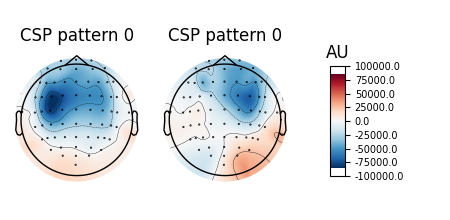

In [3]:
def train_model(epochs, info, dim_red_class=MyCSP, n_components=2):
    epochs_data_train = epochs.get_data(tmin=1.0, tmax=2.0)
    labels = epochs.events[:, 2]

    cv = ShuffleSplit(10, test_size=0.2, random_state=21)

    # Assemble the classifier
    pipeline = Pipeline([("dim_rediction", dim_red_class(n_components=n_components)), ("clf", LinearDiscriminantAnalysis())])

    # Use scikit-learn Pipeline with cross_val_score function
    scores = cross_val_score(pipeline, epochs_data_train, labels, cv=cv, n_jobs=None, error_score='raise')
    print('scores: ', end="")
    for score in scores: print(f'{score:.2f} ', end="")
    mean_accuracy = np.mean(scores)
    print(f'.\nMean accuracy: {mean_accuracy:.2f}')
    pipeline.fit(epochs_data_train, labels)
    pipeline['dim_rediction'].plot_patterns(info)
    return pipeline, mean_accuracy

clf, _ = train_model(fists_or_feet_epochs, raw.info)

### Comparing with MNE's CSP

scores: 1.00 0.78 0.89 0.89 0.89 0.89 1.00 0.89 0.89 0.78 .
Mean accuracy: 0.89


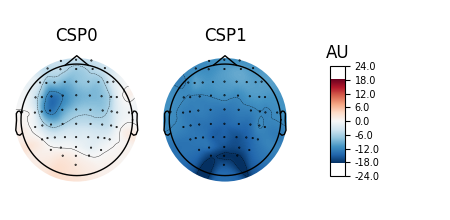

In [4]:
_ = train_model(fists_or_feet_epochs, raw.info, CSP, n_components=2)

### Replaying EEG recordings in realtime

In [ ]:
raw_data = raw.get_data()

# make stim data from events.
stim_data = np.empty((raw_data.shape[1]))
for i in range(events.shape[0] - 1):
    stim_data[events[i, 0]:events[i+1, 0]] = events[i, 2]
stim_data[events[-1, 0]:stim_data.shape[0]] = events[-1, 2]

window_size = fists_or_feet_epochs.get_data(tmin=1.0, tmax=2.0).shape[2]
for start in range(0, raw_data.shape[1]-window_size):
    data_window = [raw_data[:, start:start+window_size]]
    stim = stim_data[start + window_size]
    prediction = clf.predict(data_window)[0]
    print('start:', start,' stim:', stim, ' prediction:', prediction, ' ', 'Success' if prediction == stim else 'Failure')

### Training and testing on all runs

Loaded epochs of runs 6 10 14 .
scores: 0.89 0.89 1.00 0.89 0.78 1.00 0.89 0.78 0.89 1.00 .
Mean accuracy: 0.90


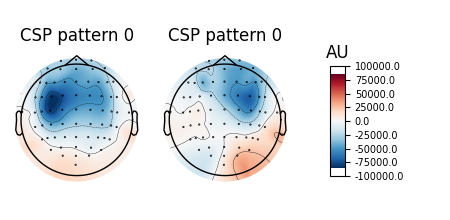


Loaded epochs of runs 3 7 11 .
scores: 0.56 0.89 0.78 0.67 0.67 0.78 0.56 0.78 0.67 0.78 .
Mean accuracy: 0.71


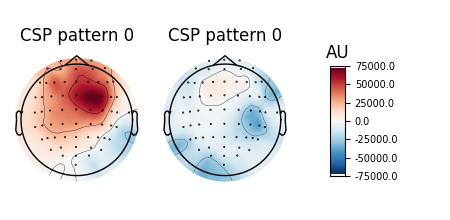


Loaded epochs of runs 4 8 12 .
scores: 0.56 0.56 0.44 0.33 0.89 0.56 0.56 0.33 0.33 0.56 .
Mean accuracy: 0.51


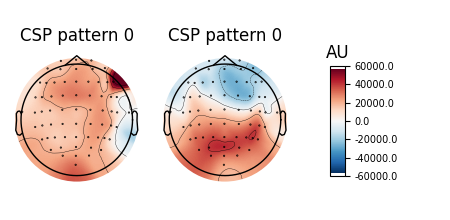


Loaded epochs of runs 5 9 13 .
scores: 1.00 0.89 1.00 0.89 0.89 1.00 1.00 0.89 1.00 1.00 .
Mean accuracy: 0.96


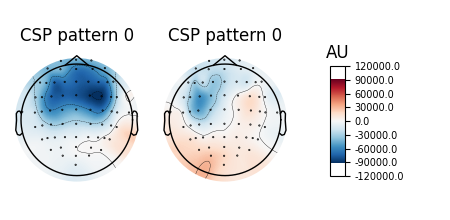


Mean accuracy: 0.77


In [6]:
runs_indices = [RIGHT_OR_LEFT_FIST, RIGHT_OR_LEFT_FIST_MI, FISTS_OR_FEET, FISTS_OR_FEET_MI]

runs_accuracies = []
for run_indices in runs_indices:
    raw, _, epochs = load_epochs(run_indices)
    _, run_accuracy = train_model(epochs, raw.info)
    runs_accuracies.append(run_accuracy)
    print()

print(f'Mean accuracy: {np.mean(runs_accuracies):.2f}')

### References

See [CSP wikipedia page](https://en.wikipedia.org/wiki/Common_spatial_pattern) and  [Koles1991](https://doi.org/10.1016/0013-4694(91)90163-X).  
The EEGBCI dataset is documented in [SchalkEtAl2004](http://doi:10.1109/TBME.2004.827072)  and is available at [PhysioNet](https://physionet.org/content/eegmmidb/1.0.0/), [GoldbergerEtAl2000](https://doi.org/10.1161/01.CIR.101.23.e215).  

- Author: Mauro Abidal Carrer <mauroabidal@yahoo.fr>  
- Orginal Authors: Martin Billinger <martin.billinger@tugraz.at>  
- Original script: https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html  
- License: BSD-3-Clause  